* This notebook was made to create three ferry routes shown in the map. 

In [1]:
from __future__ import division

import glob
import os

from dateutil import tz
from matplotlib.backends import backend_agg as backend
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
import scipy.io as sio

from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
from nowcast import figures
from datetime import datetime, timedelta
from glob import glob

%matplotlib inline
import sys
import scipy.io as sio

sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import research_ferries as rf


# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13'}

In [2]:
# Dictionary of ferry stations - new
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909},
                  'Vancouver': {'lat': 49.2827,'lon': -123.1207},
                 'Swartz': {'lat': 48.6882,'lon': -123.4102},
                'Horseshoe Bay': {'lat': 49.3742,'lon': -123.2728}
                 }

In [3]:
import datetime
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
today = datetime.datetime.today()
oneday = datetime.timedelta(days = 1)
run_date= today - oneday
date_str_yesterday = run_date.strftime('%Y%m%d')
saline=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/%s/%s_TSG%s.mat' %('HBDB', 'HBDB', date_str_yesterday))

In [4]:
date_str_yesterday

'20160419'

In [5]:
def salinity_ferry_route(grid_B, PNW_coastline):
    """ [Description here]
    
    :arg grid_B: Bathymetry dataset for the Salish Sea NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg PNW_coastline: Coastline dataset.
    :type PNW_coastline: :class:`mat.Dataset`
    
    :arg ferry_sal: saline
    :type ferry_sal: numpy
    
    :returns: fig
    """

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    
    figures.plot_map(axs,PNW_coastline)
    #viz_tools.plot_coastline(axs,bathy,coords='map')
    #axs.set_title('Ferry Stations', **title_font)
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.8)
    stationsTWDP=['Tsawwassen','Duke']
    stationsHBDB=['Horseshoe Bay','Duke']
    stationsTWSB=['Swartz','Vancouver']
    routes = ['TWDP','HBDB','TWSB']
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    
    for stn in stationsTWDP:
        axs.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='tomato',\
                 markersize=10, markeredgewidth=2)
        
    for stn in stationsHBDB:
        axs.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='tomato',\
                 markersize=10, markeredgewidth=2)
        
    for stn in stationsTWSB:
        axs.plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='tomato',\
                 markersize=10, markeredgewidth=2)
        
    axs.annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon'] + 0.022,\
    ferry_stations['Tsawwassen']['lat'] + 0.052), fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Swartz',(ferry_stations['Swartz']['lon'] - 0.45,\
    ferry_stations['Swartz']['lat'] - 0.1 ),fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Vancouver',(ferry_stations['Vancouver']['lon'] + 0.02,\
    ferry_stations['Vancouver']['lat']- 0.10 ),fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Horseshoe Bay',(ferry_stations['Horseshoe Bay']['lon'] + 0.022,\
    ferry_stations['Horseshoe Bay']['lat'] + 0.052), fontsize=15, color='black', bbox=bbox_args )
    axs.annotate ('Duke Point',(ferry_stations['Duke']['lon'] - 0.45,\
    ferry_stations['Duke']['lat'] ),fontsize=15, color='black', bbox=bbox_args )
    #figures.axis_colors(axs[1], 'white')
    #figures.axis_colors(axs[1], 'white')
    axs.set_xlim([-124.5,-122.5])
    axs.set_ylim([48.2,49.5])
    
    for route,c in zip(routes,colors):
        saline=sio.loadmat('/ocean/jieliu/research/meopar/ONC_ferries/%s/%s_TSG%s.mat' \
                           %(route, route, date_str_yesterday))
        lon11, lat11, lon1_2_4, lat1_2_4, value_mean_3rd_hour, value_mean_4rd_hour,\
        salinity11, salinity1_2_4,date_str_title = rf.salinity_fxn(saline, route, today)
        axs.plot(lon11,lat11,color=c, linewidth = 4)
        print(route)
   
    return fig

TWDP
HBDB
TWSB


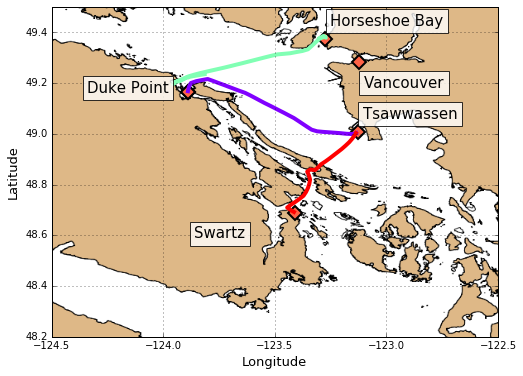

In [6]:
fig = salinity_ferry_route(bathy, PNW_coastline)

In [7]:
fig.savefig('ferryroute.png')